In [1]:
# train_models.py
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import dump
import tensorflow as tf


In [2]:
# ------------------------------------------------------------------
# Carga de datos
# ------------------------------------------------------------------
DATA_DIR = Path('.')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df   = pd.read_csv(DATA_DIR / 'val.csv')
test_df  = pd.read_csv(DATA_DIR / 'test_baseline.csv')
levels_df  = pd.read_csv(DATA_DIR / 'plagiarism_levels.csv')
target_col  = 'result'


In [3]:
# ------------------------------------------------------------------
# Cargar cadenas de MArkov
# ------------------------------------------------------------------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    """Convierte la cadena '0.123 0.0 …' en vector float32."""
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

def build_feature_matrix(df: pd.DataFrame) -> np.ndarray:
    """
    Output:  [simhash, astsimilarity,  markov1(flat) , markov2(flat) , |diff| ]
              └─2 cols──┘          └────────── 3 × L  ───────────────┘
    """
    base   = df[["simhash", "astsimilarity"]].values.astype("float32")

    m1 = np.vstack(df["markov1"].apply(str_to_vec))
    m2 = np.vstack(df["markov2"].apply(str_to_vec))
    diff = np.abs(m1 - m2)

    return np.hstack([base, m1, m2, diff])

vlen   = len(str_to_vec(train_df["markov1"].iloc[0]))
dim_v  = int(np.sqrt(vlen))
print(f"Vocab Markov detectado: {dim_v} nodos  =>  {vlen} números por matriz")


Vocab Markov detectado: 52 nodos  =>  2704 números por matriz


In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------
#  Función para convertir cadena "0.123 0.456 …" en np.ndarray
# --------------------------------------------------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    """Convierte la cadena '0.123 0.0 …' en vector float32."""
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

# --------------------------------------------------
# Extraer sub-árboles desde train_df, val_df, etc.
# --------------------------------------------------

# Base (simhash + astsimilarity)
base_train = train_df[["simhash", "astsimilarity"]].values.astype("float32")  # shape = (N_train, 2)
base_val   = val_df  [ ["simhash", "astsimilarity"] ].values.astype("float32")
base_test  = test_df [ ["simhash", "astsimilarity"] ].values.astype("float32")
base_levels= levels_df[["simhash", "astsimilarity"]].values.astype("float32")

# Markov – solo extraemos m1/m2 para luego augmentar train
m1_train = np.vstack(train_df["markov1"].apply(str_to_vec))   # (N_train, vlen)
m2_train = np.vstack(train_df["markov2"].apply(str_to_vec))   # (N_train, vlen)

m1_val   = np.vstack(val_df  ["markov1"].apply(str_to_vec))
m2_val   = np.vstack(val_df  ["markov2"].apply(str_to_vec))

m1_test  = np.vstack(test_df ["markov1"].apply(str_to_vec))
m2_test  = np.vstack(test_df ["markov2"].apply(str_to_vec))

m1_levels= np.vstack(levels_df["markov1"].apply(str_to_vec))
m2_levels= np.vstack(levels_df["markov2"].apply(str_to_vec))

# Las etiquetas
y_train  = train_df [target_col].astype("int8").values  # (N_train,)
y_val    = val_df   [target_col].astype("int8").values
y_test   = test_df  [target_col].astype("int8").values
y_levels = levels_df[target_col].astype("int8").values

# --------------------------------------------------
# Definimos la función para augmentar pares (m1, m2)
# --------------------------------------------------
def augment_markov_pairs(m1: np.ndarray, m2: np.ndarray, H: int, W: int) -> (np.ndarray, np.ndarray):
    """
    Para cada par (m1[i], m2[i]) con forma plana (F,), genera 5 variantes (original + 4 shifts aleatorios).
    Retorna dos arrays (m1_aug, m2_aug) de forma (5*N, F).
    """
    N, F = m1.shape
    assert F == H * W, f"Las filas de m1 deberían tener H*W={H*W} columnas, pero tienen {F}."
    assert m2.shape == (N, F), "m1 y m2 deben tener la misma forma."

    rng = np.random.default_rng()
    augmented_m1 = []
    augmented_m2 = []

    for i in range(N):
        vec1 = m1[i].reshape((H, W))
        vec2 = m2[i].reshape((H, W))

        # Variante original (sin mover nada)
        augmented_m1.append(vec1.ravel())
        augmented_m2.append(vec2.ravel())

        # Shift vertical hacia abajo con pasos aleatorios en [1, H-1]
        k_down = rng.integers(1, H)
        m1_down = np.roll(vec1, shift=k_down, axis=0)
        m2_down = np.roll(vec2, shift=k_down, axis=0)
        augmented_m1.append(m1_down.ravel())
        augmented_m2.append(m2_down.ravel())

        # Shift vertical hacia arriba con pasos aleatorios en [1, H-1]
        k_up = rng.integers(1, H)
        m1_up = np.roll(vec1, shift=-k_up, axis=0)
        m2_up = np.roll(vec2, shift=-k_up, axis=0)
        augmented_m1.append(m1_up.ravel())
        augmented_m2.append(m2_up.ravel())

        # Shift horizontal hacia la derecha con pasos aleatorios en [1, W-1]
        k_right = rng.integers(1, W)
        m1_right = np.roll(vec1, shift=k_right, axis=1)
        m2_right = np.roll(vec2, shift=k_right, axis=1)
        augmented_m1.append(m1_right.ravel())
        augmented_m2.append(m2_right.ravel())

        # Shift horizontal hacia la izquierda con pasos aleatorios en [1, W-1]
        k_left = rng.integers(1, W)
        m1_left = np.roll(vec1, shift=-k_left, axis=1)
        m2_left = np.roll(vec2, shift=-k_left, axis=1)
        augmented_m1.append(m1_left.ravel())
        augmented_m2.append(m2_left.ravel())
        
        # Shift diagonal hacia abajo-derecha
        k_dr = (rng.integers(1, H), rng.integers(1, W))
        m1_dr = np.roll(np.roll(vec1, shift=k_dr[0], axis=0), shift=k_dr[1], axis=1)
        m2_dr = np.roll(np.roll(vec2, shift=k_dr[0], axis=0), shift=k_dr[1], axis=1)
        augmented_m1.append(m1_dr.ravel())
        augmented_m2.append(m2_dr.ravel())

        # Shift diagonal hacia abajo-izquierda
        k_dl = (rng.integers(1, H), rng.integers(1, W))
        m1_dl = np.roll(np.roll(vec1, shift=k_dl[0], axis=0), shift=-k_dl[1], axis=1)
        m2_dl = np.roll(np.roll(vec2, shift=k_dl[0], axis=0), shift=-k_dl[1], axis=1)
        augmented_m1.append(m1_dl.ravel())
        augmented_m2.append(m2_dl.ravel())

        # Shift diagonal hacia arriba-derecha
        k_ur = (rng.integers(1, H), rng.integers(1, W))
        m1_ur = np.roll(np.roll(vec1, shift=-k_ur[0], axis=0), shift=k_ur[1], axis=1)
        m2_ur = np.roll(np.roll(vec2, shift=-k_ur[0], axis=0), shift=k_ur[1], axis=1)
        augmented_m1.append(m1_ur.ravel())
        augmented_m2.append(m2_ur.ravel())

        # Shift diagonal hacia arriba-izquierda
        k_ul = (rng.integers(1, H), rng.integers(1, W))
        m1_ul = np.roll(np.roll(vec1, shift=-k_ul[0], axis=0), shift=-k_ul[1], axis=1)
        m2_ul = np.roll(np.roll(vec2, shift=-k_ul[0], axis=0), shift=-k_ul[1], axis=1)
        augmented_m1.append(m1_ul.ravel())
        augmented_m2.append(m2_ul.ravel())

    # Convertir listas a np.ndarray
    return np.vstack(augmented_m1), np.vstack(augmented_m2)


# --------------------------------------------------
# Ejecutamos el augment SOLO sobre el train set de Markov
# --------------------------------------------------
# Sabemos que vlen = H*W y dim_v = H = W (extraído antes)
vlen = m1_train.shape[1]
dim_v = int(np.sqrt(vlen))
H, W = dim_v, dim_v

# Augmentamos pares (m1_train, m2_train)
m1_train_aug, m2_train_aug = augment_markov_pairs(m1_train, m2_train, H, W)

# Cada fila original genera 9 filas augmentadas
n_augment = m1_train_aug.shape[0] // m1_train.shape[0]
# Repetimos etiquetas
y_train = np.repeat(y_train, n_augment)  # shape = (5*N_train,)

# --------------------------------------------------
# Ahora recomputamos diff = |m1 − m2| sobre el conjunto aumentado
# --------------------------------------------------
diff_train_aug = np.abs(m1_train_aug - m2_train_aug)

# --------------------------------------------------
# Repetimos la parte “base” (simhash + astsimilarity) 9 veces
# --------------------------------------------------
base_train_aug = np.repeat(base_train, n_augment, axis=0)

# --------------------------------------------------
# Armamos X_train_aug completo: [base, m1, m2, diff]
# --------------------------------------------------
X_train_aug = np.hstack([
    base_train_aug,           # (5*N_train, 2)
    m1_train_aug,             # (5*N_train, vlen)
    m2_train_aug,             # (5*N_train, vlen)
    diff_train_aug            # (5*N_train, vlen)
])

# --------------------------------------------------
# Para val/test/levels usamos sin augment:
# --------------------------------------------------
diff_val   = np.abs(m1_val   - m2_val)
diff_test  = np.abs(m1_test  - m2_test)
diff_levels= np.abs(m1_levels- m2_levels)

X_val     = np.hstack([base_val,    m1_val,    m2_val,    diff_val   ])
X_test    = np.hstack([base_test,   m1_test,   m2_test,   diff_test  ])
X_levels  = np.hstack([base_levels, m1_levels, m2_levels, diff_levels])

# --------------------------------------------------
# Escalado numérico: fit_transform en el train aumentado
# --------------------------------------------------
scaler = StandardScaler()
X_train_sc  = scaler.fit_transform(X_train_aug)
X_val_sc    = scaler.transform(X_val)
X_test_sc   = scaler.transform(X_test)
X_levels_sc = scaler.transform(X_levels)

print(f"X_train_sc shape: {X_train_sc.shape}")
print(f"Y_train_aug shape: {y_train.shape}")


X_train_sc shape: (17712, 8114)
Y_train_aug shape: (17712,)


In [5]:

# ------------------------------------------------------------------
# 3. Modelo 0 — Baseline con TensorFlow
# ------------------------------------------------------------------
def build_tf_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

tf_model = build_tf_model(X_train_sc.shape[1])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

# callback para medir test accuracy al final de cada época
test_accuracies = []
test_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: test_accuracies.append(
        tf_model.evaluate(X_test_sc, y_test, verbose=0)[1]
    )
)

history = tf_model.fit(
    X_train_sc, y_train,
    validation_data=(X_val_sc, y_val),
    epochs=500, batch_size=256, verbose=0,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        test_callback
    ]
)

print('\n🟢 TensorFlow — Test metrics')
tf_metrics = tf_model.evaluate(X_test_sc, y_test, verbose=0)
for name, val in zip(tf_model.metrics_names, tf_metrics):
    print(f'{name}: {val:.4f}')
tf_model.save('tf_baseline.keras')




🟢 TensorFlow — Test metrics
loss: 0.3351
accuracy: 0.8614
auc: 0.9308


In [7]:

# ------------------------------------------------------------------
# 4. Modelo 1 — Regresión logística
# ------------------------------------------------------------------
logreg = LogisticRegression(max_iter=2000, n_jobs=-1)
logreg.fit(X_train_sc, y_train)
print('\n🟢 LogReg — Val accuracy:',
      accuracy_score(y_val, logreg.predict(X_val_sc)))
dump(('scaler', scaler, 'logreg', logreg), 'logreg.joblib')


# %%



🟢 LogReg — Val accuracy: 0.8090614886731392


['logreg.joblib']

In [8]:
# ------------------------------------------------------------------
# 5. Modelo 2 — Random Forest
# ------------------------------------------------------------------
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42)
rf.fit(X_train_aug, y_train)
print('\n🟢 RandomForest — Val accuracy:',
      accuracy_score(y_val, rf.predict(X_val)))
dump(rf, 'rf.joblib')


# %%


🟢 RandomForest — Val accuracy: 0.7135922330097088


['rf.joblib']

In [9]:
# ------------------------------------------------------------------
# 6. Modelo 3 — XGBoost
# ------------------------------------------------------------------
xgb_clf = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42)

xgb_clf.fit(X_train_aug, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

print('\n🟢 XGBoost — Val accuracy:',
      accuracy_score(y_val, (xgb_clf.predict(X_val) > 0.5)))
xgb_clf.save_model('xgb.json')




🟢 XGBoost — Val accuracy: 0.7621359223300971


In [10]:

# 7. Comparación final en TEST
# ------------------------------------------------------------------
def evaluate(name, y_true, y_pred, y_prob):
    print(f'🔸 {name}: acc={accuracy_score(y_true, y_pred):.4f}',
          f'f1={f1_score(y_true, y_pred):.4f}',
          f'auc={roc_auc_score(y_true, y_prob):.4f}')

print('\n📊  Métricas finales en TEST:')
evaluate('LogReg',
         y_test,
         logreg.predict(X_test_sc),
         logreg.predict_proba(X_test_sc)[:,1])

evaluate('RandomForest',
         y_test,
         rf.predict(X_test),
         rf.predict_proba(X_test)[:,1])

evaluate("XGBoost",
         y_test,
         (xgb_clf.predict(X_test) > 0.5),
         xgb_clf.predict_proba(X_test)[:,1])

tf_pred_prob = tf_model.predict(X_test_sc).ravel()
tf_pred_bin  = (tf_pred_prob > 0.5).astype(int)
evaluate("TensorFlow", y_test, tf_pred_bin, tf_pred_prob)


# %%


📊  Métricas finales en TEST:
🔸 LogReg: acc=0.9187 f1=0.9143 auc=0.9621
🔸 RandomForest: acc=0.9127 f1=0.9024 auc=0.9862
🔸 XGBoost: acc=0.8946 f1=0.8903 auc=0.9657
11/11 [==============================] - 0s 2ms/step
🔸 TensorFlow: acc=0.8614 f1=0.8571 auc=0.9308


In [11]:
# ---------------------------------------------------------------
#  MATRICES DE CONFUSIÓN (set de TEST)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.rcParams["figure.figsize"] = (5.5, 5.5)

# --- predicciones ------------------------------------------------
y_pred_logreg = logreg.predict(X_test_sc)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = (xgb_clf.predict(X_test) > 0.5).astype(int)
tf_prob = tf_model.predict(X_test_sc).ravel()
y_pred_tf = (tf_prob > 0.5).astype(int)

# --- modelos + preds en un dict ---------------------------------
models = {
    "LogReg" : y_pred_logreg,
    "RandomForest" : y_pred_rf,
    "XGBoost" : y_pred_xgb,
    "TensorFlow" : y_pred_tf
}

11/11 [==============================] - 0s 3ms/step


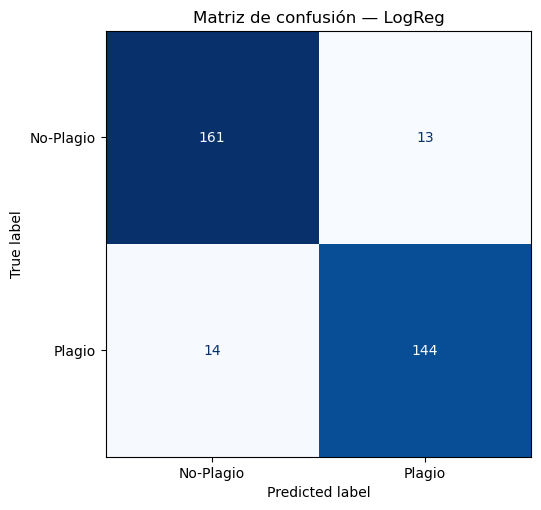


Reporte de clasificación — LogReg
              precision    recall  f1-score   support

   No-Plagio       0.92      0.93      0.92       174
      Plagio       0.92      0.91      0.91       158

    accuracy                           0.92       332
   macro avg       0.92      0.92      0.92       332
weighted avg       0.92      0.92      0.92       332



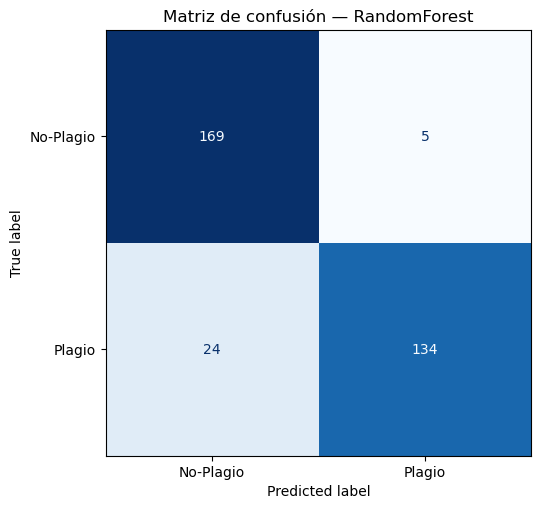


Reporte de clasificación — RandomForest
              precision    recall  f1-score   support

   No-Plagio       0.88      0.97      0.92       174
      Plagio       0.96      0.85      0.90       158

    accuracy                           0.91       332
   macro avg       0.92      0.91      0.91       332
weighted avg       0.92      0.91      0.91       332



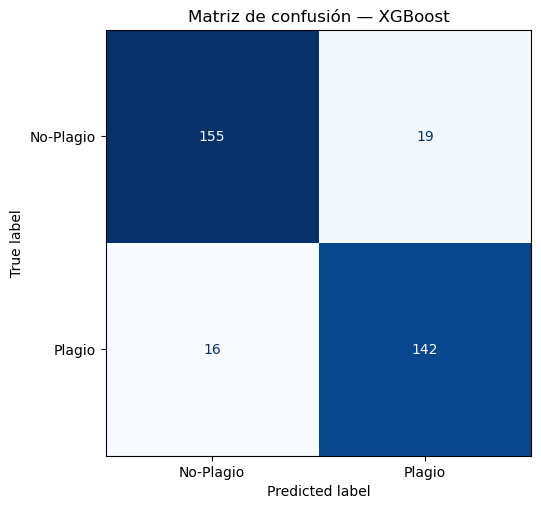


Reporte de clasificación — XGBoost
              precision    recall  f1-score   support

   No-Plagio       0.91      0.89      0.90       174
      Plagio       0.88      0.90      0.89       158

    accuracy                           0.89       332
   macro avg       0.89      0.89      0.89       332
weighted avg       0.89      0.89      0.89       332



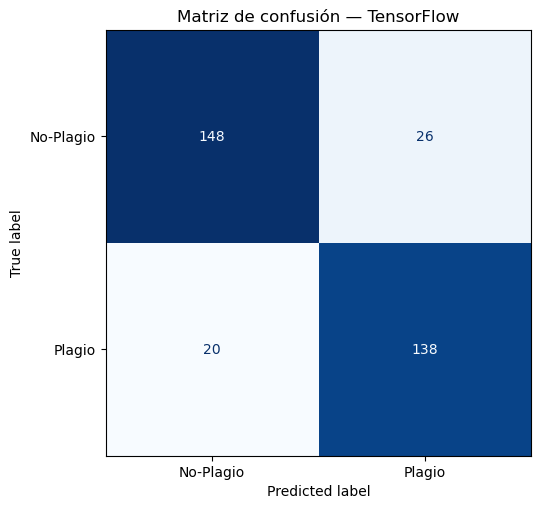


Reporte de clasificación — TensorFlow
              precision    recall  f1-score   support

   No-Plagio       0.88      0.85      0.87       174
      Plagio       0.84      0.87      0.86       158

    accuracy                           0.86       332
   macro avg       0.86      0.86      0.86       332
weighted avg       0.86      0.86      0.86       332



In [12]:

# --- dibuja e imprime -------------------------------------------
for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No-Plagio", "Plagio"])
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title(f"Matriz de confusión — {name}")
    plt.tight_layout()
    plt.show()

    print(f"\nReporte de clasificación — {name}")
    print(classification_report(y_test, y_pred,
                                target_names=["No-Plagio", "Plagio"]))

29/29 [==============================] - 0s 2ms/step


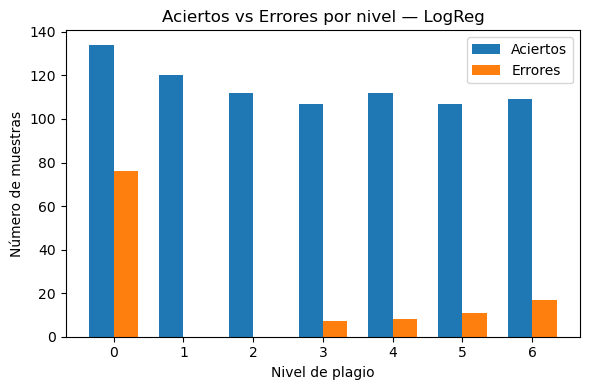

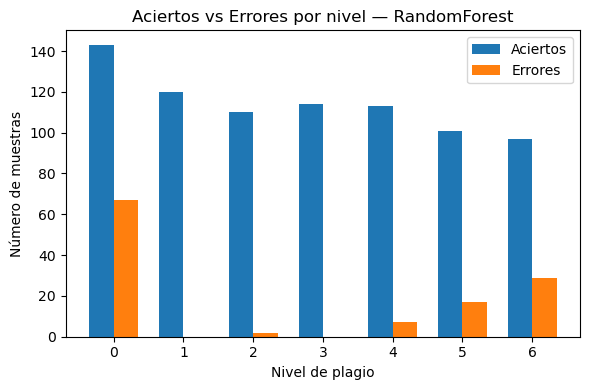

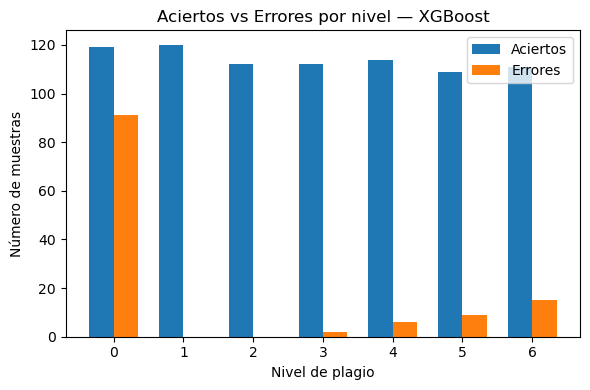

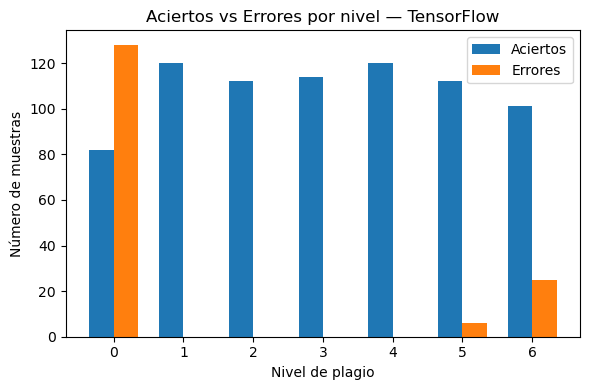

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Predicciones sobre el conjunto de niveles
y_pred_logreg_lvl    = logreg.predict(X_levels_sc)
y_pred_rf_lvl        = rf.predict(X_levels)
y_pred_xgb_lvl       = (xgb_clf.predict(X_levels) > 0.5).astype(int)
tf_prob_lvl          = tf_model.predict(X_levels_sc).ravel()
y_pred_tf_lvl        = (tf_prob_lvl > 0.5).astype(int)

models_levels = {
    "LogReg"       : y_pred_logreg_lvl,
    "RandomForest" : y_pred_rf_lvl,
    "XGBoost"      : y_pred_xgb_lvl,
    "TensorFlow"   : y_pred_tf_lvl
}

# Etiquetas reales y niveles de plagio
actual_levels = levels_df["plagiarism_level"].values
true_labels   = levels_df[target_col].astype("int8").values

levels = np.unique(actual_levels)
levels.sort()

# Graficar aciertos vs errores por nivel para cada modelo 
for name, y_pred in models_levels.items():
    correct   = []
    incorrect = []
    for lvl in levels:
        mask = (actual_levels == lvl)
        corr = (y_pred[mask] == true_labels[mask]).sum()
        total = mask.sum()
        correct.append(corr)
        incorrect.append(total - corr)

    x = np.arange(len(levels))
    width = 0.35

    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, correct,   width, label="Aciertos")
    plt.bar(x + width/2, incorrect, width, label="Errores")
    plt.xticks(x, levels)
    plt.xlabel("Nivel de plagio")
    plt.ylabel("Número de muestras")
    plt.title(f"Aciertos vs Errores por nivel — {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


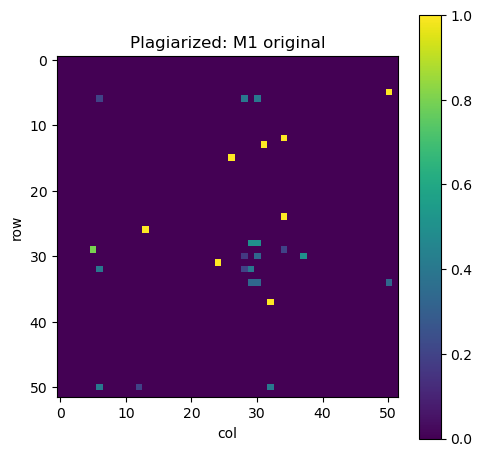

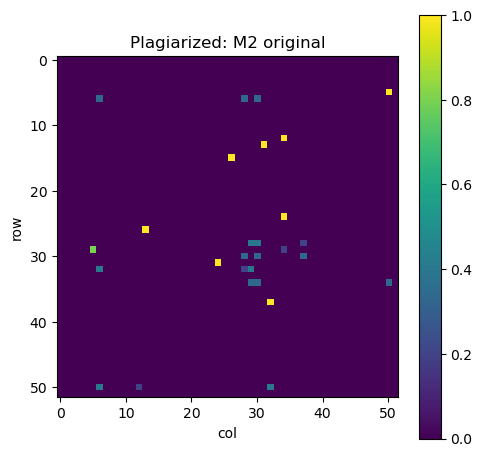

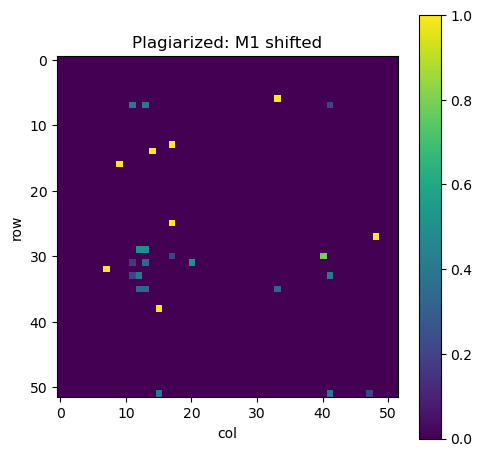

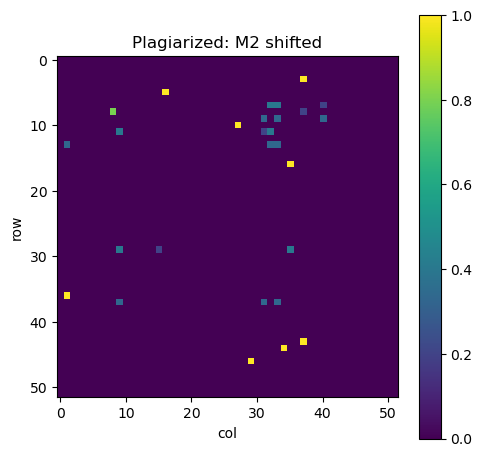

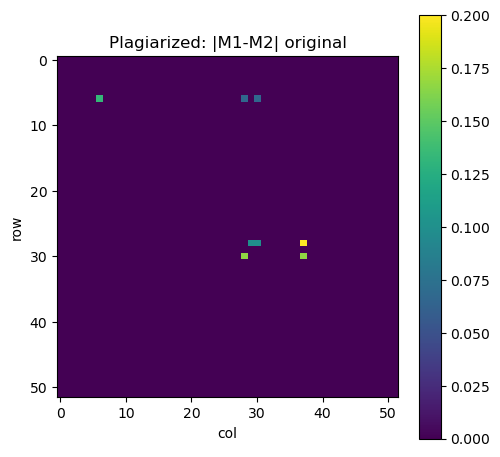

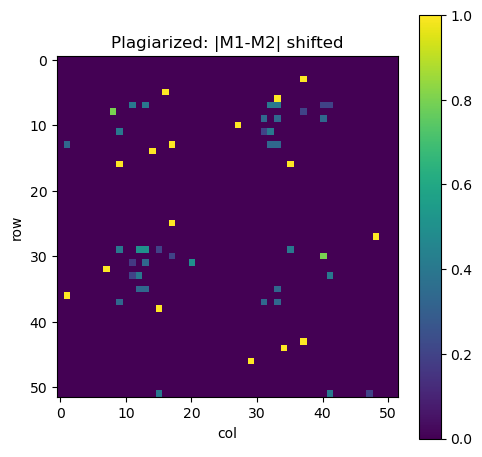

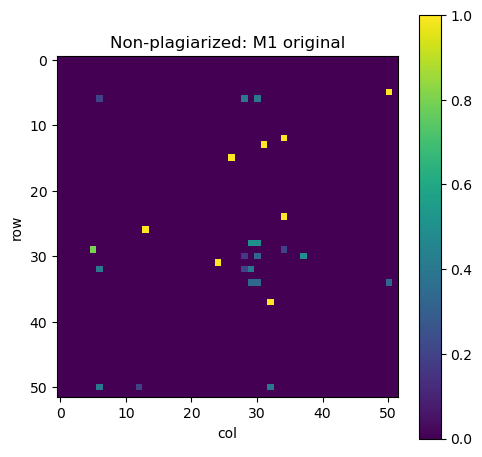

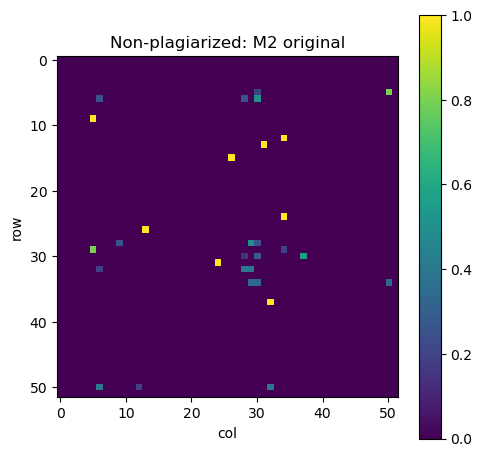

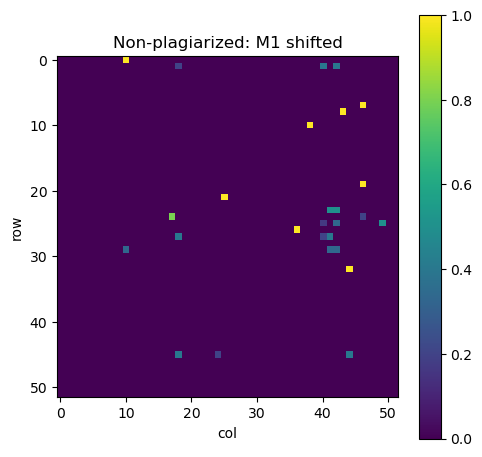

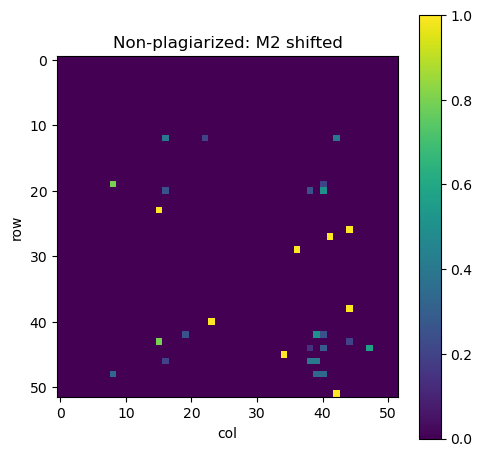

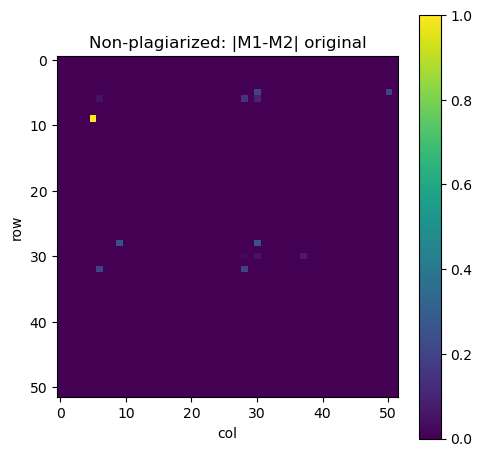

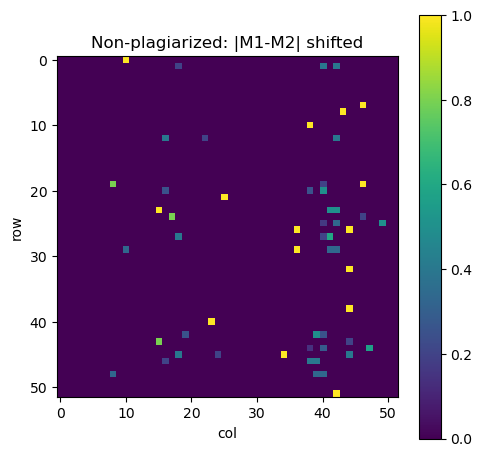

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------- helper functions --------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    """Convert Markov matrix string to float32 vector."""
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

def to_matrix(vec: np.ndarray) -> np.ndarray:
    dim = int(np.sqrt(len(vec)))
    return vec.reshape((dim, dim))

def random_shift(mat: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """Apply a random diagonal down-right shift (row + col)"""
    H, W = mat.shape
    k_row = rng.integers(1, H)
    k_col = rng.integers(1, W)
    return np.roll(np.roll(mat, shift=k_row, axis=0), shift=k_col, axis=1)

# -------- load data --------
DATA_DIR = Path('.')
train_df = pd.read_csv(DATA_DIR / 'train.csv')

# pick first plagiarized (result=1) and first non-plagiarized (result=0)
pla_row = train_df[train_df['result'] == 1].iloc[0]
nop_row = train_df[train_df['result'] == 0].iloc[0]

pairs = {
    "Plagiarized": pla_row,
    "Non-plagiarized": nop_row
}

rng = np.random.default_rng(123)

for label, row in pairs.items():
    m1_vec = str_to_vec(row["markov1"])
    m2_vec = str_to_vec(row["markov2"])
    M1 = to_matrix(m1_vec)
    M2 = to_matrix(m2_vec)
    M1_shift = random_shift(M1, rng)
    M2_shift = random_shift(M2, rng)
    diff_orig = np.abs(M1 - M2)
    diff_shift = np.abs(M1_shift - M2_shift)

    # --- original matrices heatmaps ---
    plt.figure()
    plt.imshow(M1)
    plt.colorbar()
    plt.title(f"{label}: M1 original")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

    plt.figure()
    plt.imshow(M2)
    plt.colorbar()
    plt.title(f"{label}: M2 original")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

    # --- shifted matrices heatmaps ---
    plt.figure()
    plt.imshow(M1_shift)
    plt.colorbar()
    plt.title(f"{label}: M1 shifted")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

    plt.figure()
    plt.imshow(M2_shift)
    plt.colorbar()
    plt.title(f"{label}: M2 shifted")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

    # --- diff heatmaps ---
    plt.figure()
    plt.imshow(diff_orig)
    plt.colorbar()
    plt.title(f"{label}: |M1-M2| original")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

    plt.figure()
    plt.imshow(diff_shift)
    plt.colorbar()
    plt.title(f"{label}: |M1-M2| shifted")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()


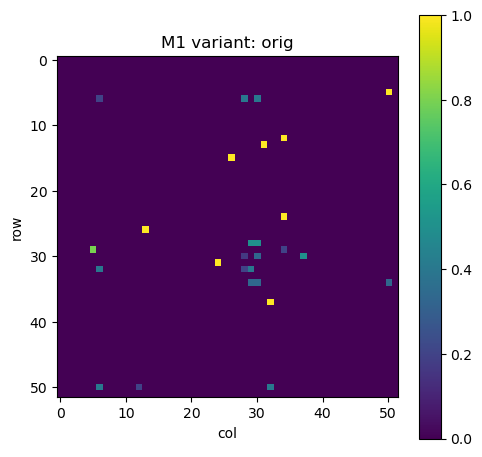

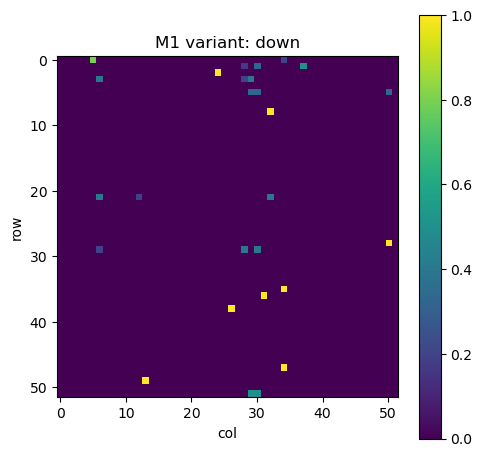

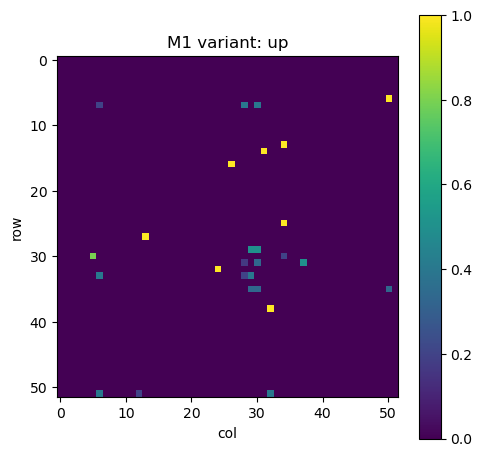

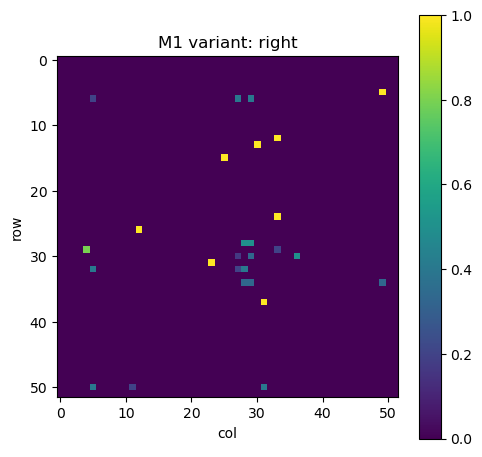

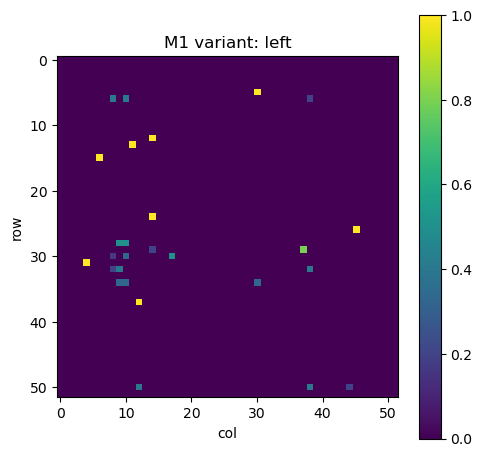

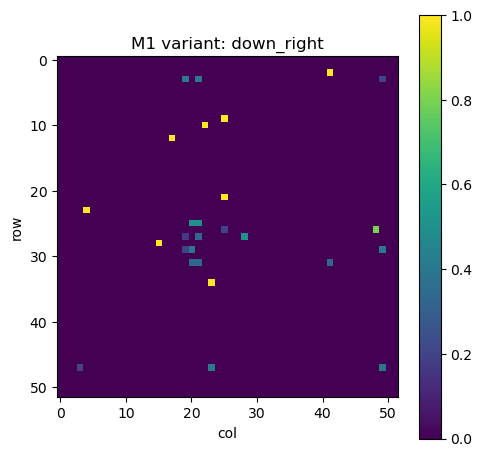

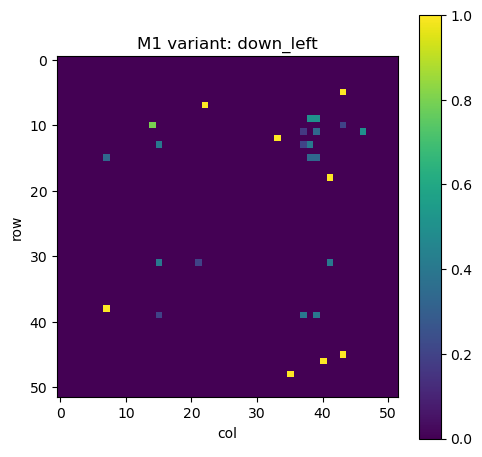

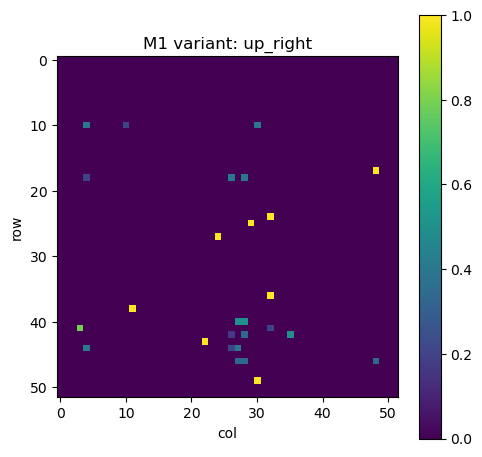

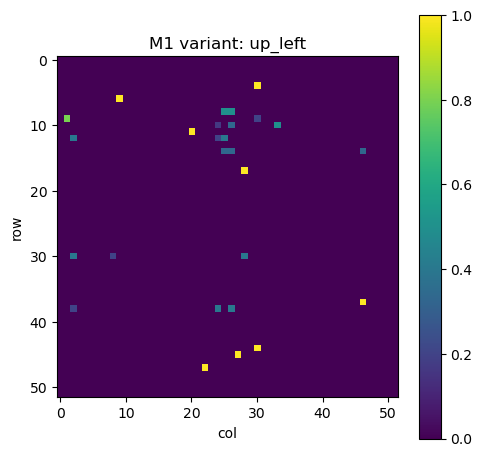

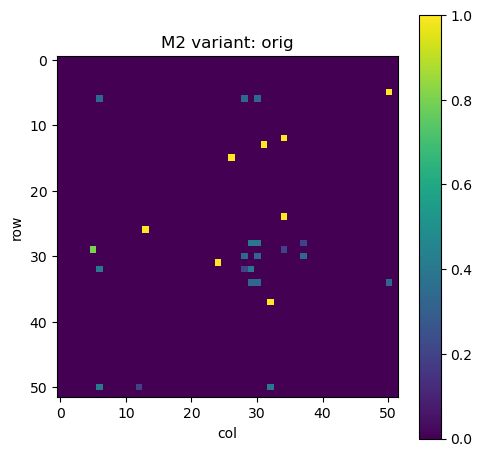

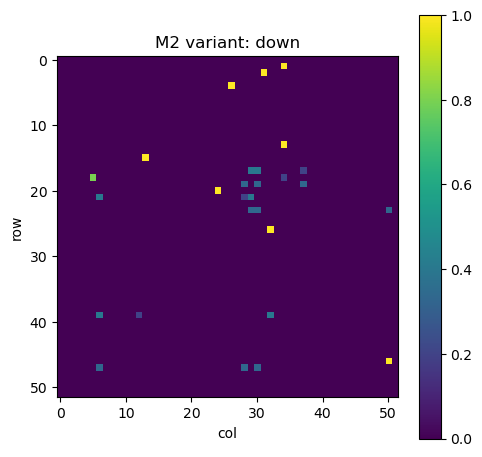

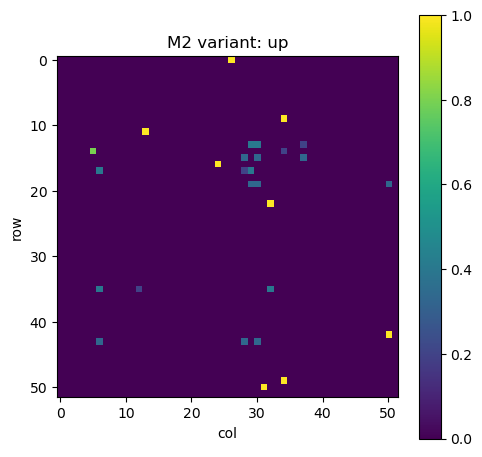

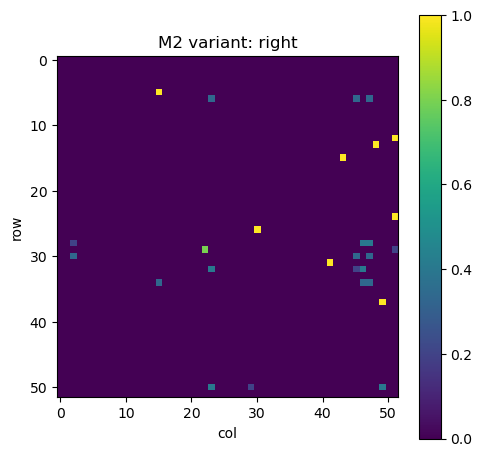

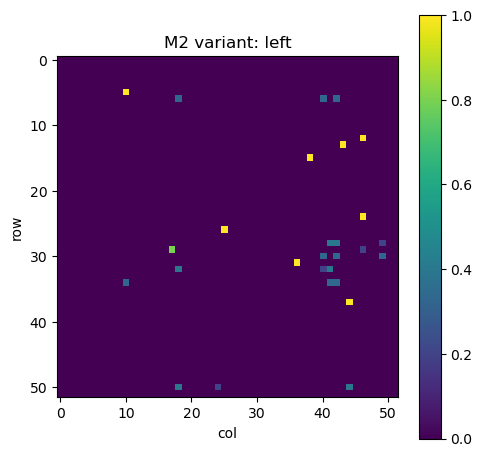

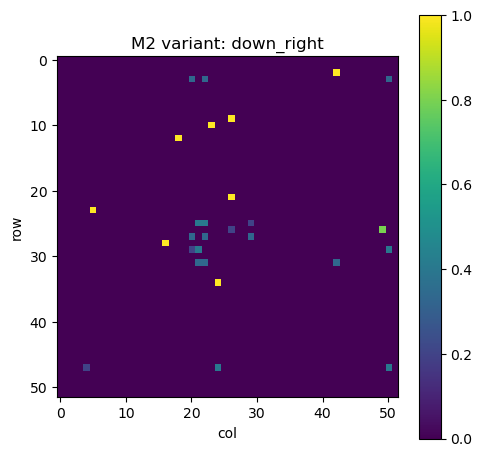

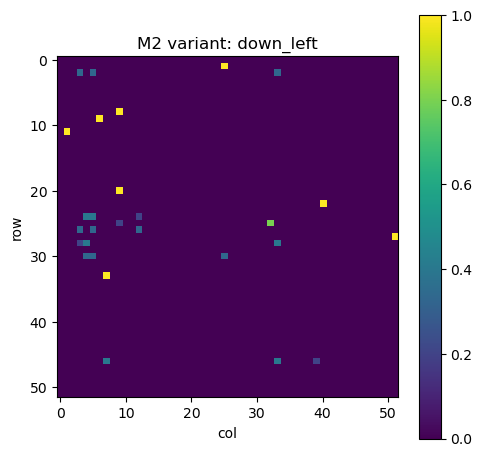

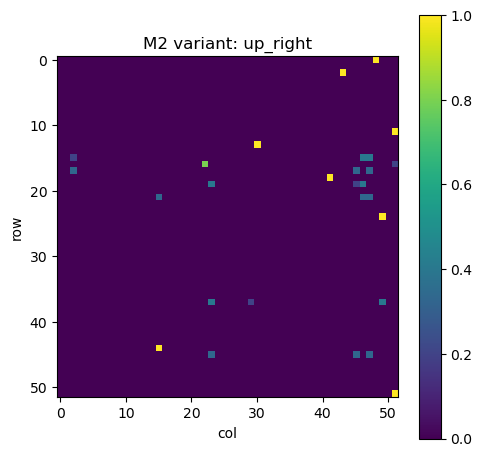

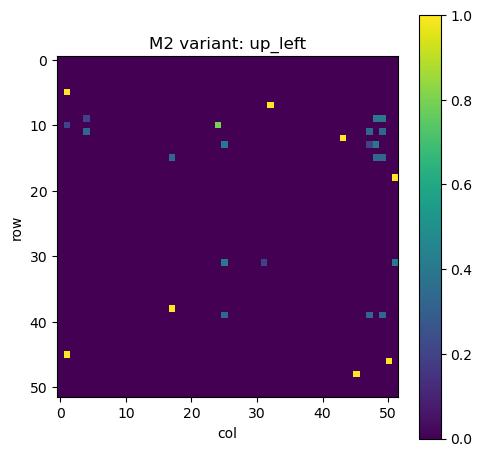

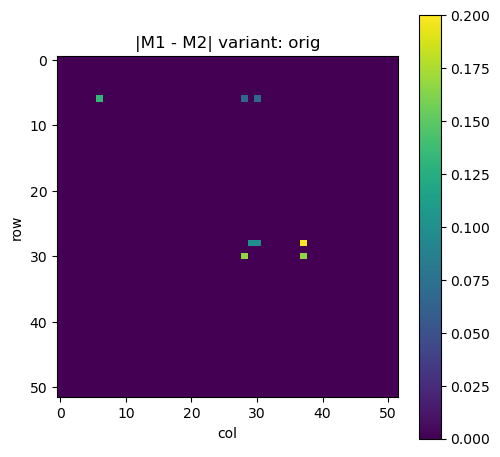

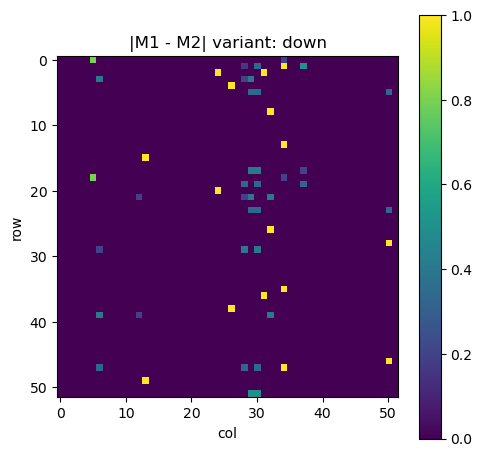

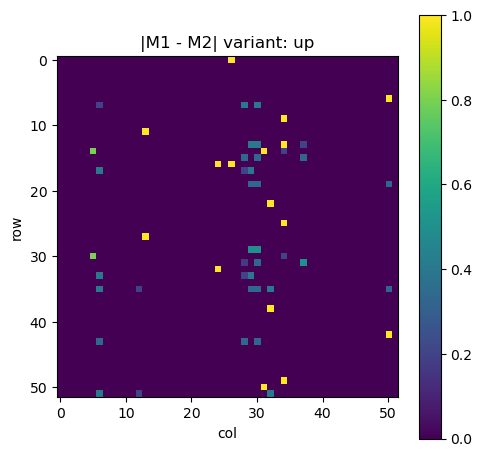

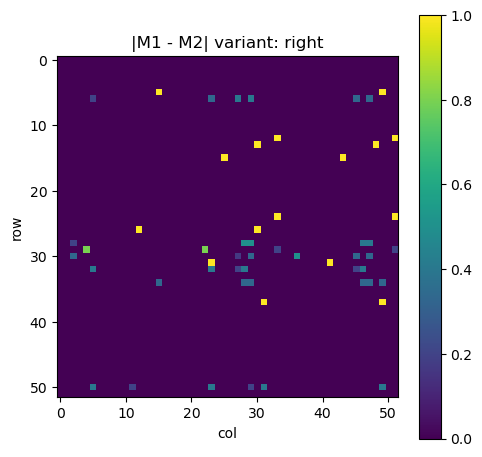

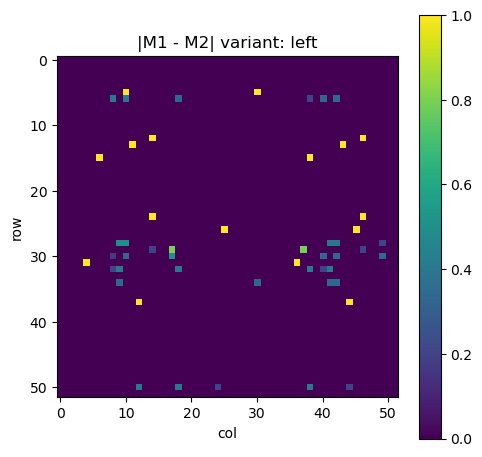

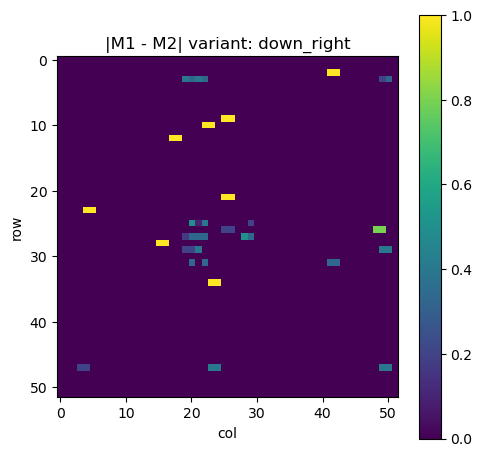

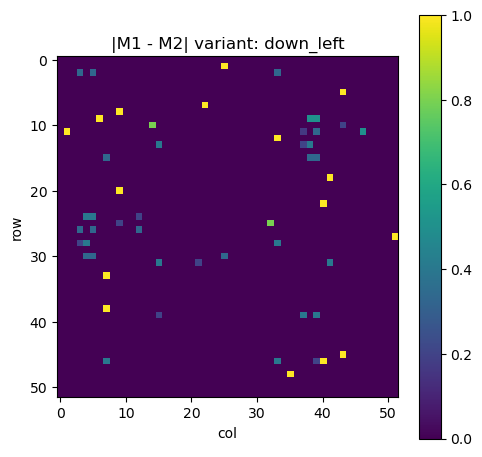

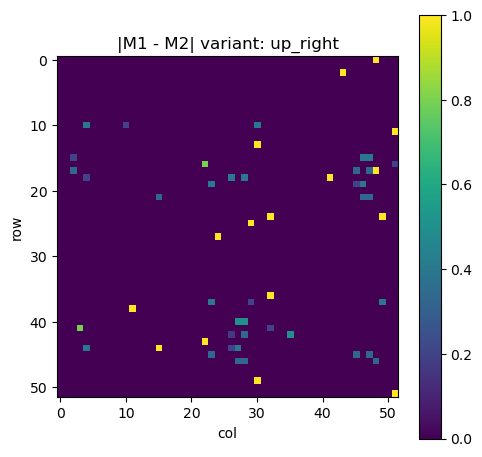

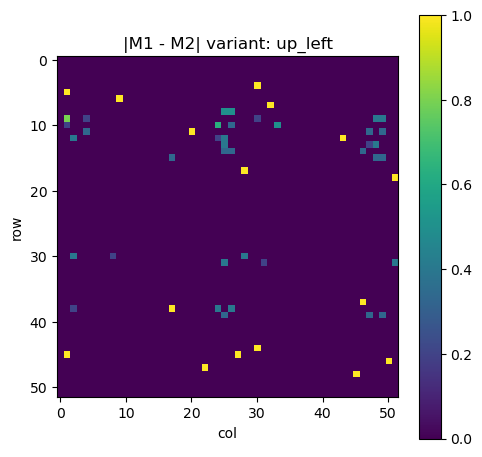

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helper utilities ------------
SPACE = " "
def str_to_vec(s: str) -> np.ndarray:
    return np.fromstring(s, sep=SPACE, dtype=np.float32)

def to_matrix(vec: np.ndarray) -> np.ndarray:
    dim = int(np.sqrt(len(vec)))
    return vec.reshape((dim, dim))

def all_augmented_variants(mat: np.ndarray, rng: np.random.Generator):
    """Yield a dictionary {name: shifted_matrix} covering the 9 variants"""
    H, W = mat.shape
    variants = {}
    variants["orig"] = mat
    # up/down
    variants["down"] = np.roll(mat, shift=rng.integers(1, H), axis=0)
    variants["up"]   = np.roll(mat, shift=-rng.integers(1, H), axis=0)
    # left/right
    variants["right"] = np.roll(mat, shift=rng.integers(1, W), axis=1)
    variants["left"]  = np.roll(mat, shift=-rng.integers(1, W), axis=1)
    # diagonals
    k_dr = (rng.integers(1, H), rng.integers(1, W))
    variants["down_right"] = np.roll(np.roll(mat, k_dr[0], axis=0), k_dr[1], axis=1)
    k_dl = (rng.integers(1, H), rng.integers(1, W))
    variants["down_left"]  = np.roll(np.roll(mat, k_dl[0], axis=0), -k_dl[1], axis=1)
    k_ur = (rng.integers(1, H), rng.integers(1, W))
    variants["up_right"]   = np.roll(np.roll(mat, -k_ur[0], axis=0), k_ur[1], axis=1)
    k_ul = (rng.integers(1, H), rng.integers(1, W))
    variants["up_left"]    = np.roll(np.roll(mat, -k_ul[0], axis=0), -k_ul[1], axis=1)
    return variants

# ---------- load one example -------------
DATA_DIR = Path('.')
train_df = pd.read_csv(DATA_DIR / 'train.csv')

# choose first plagiarized example (result==1)
row = train_df[train_df['result'] == 1].iloc[0]

m1_vec = str_to_vec(row["markov1"])
m2_vec = str_to_vec(row["markov2"])
M1 = to_matrix(m1_vec)
M2 = to_matrix(m2_vec)

rng = np.random.default_rng(2025)

# generate variants
variants_M1 = all_augmented_variants(M1, rng)
variants_M2 = {name: all_augmented_variants(M2, rng)[name] for name in variants_M1.keys()}

# --------- plot MANY augmentations ---------
for name, mat in variants_M1.items():
    plt.figure()
    plt.imshow(mat)
    plt.colorbar()
    plt.title(f"M1 variant: {name}")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

for name, mat in variants_M2.items():
    plt.figure()
    plt.imshow(mat)
    plt.colorbar()
    plt.title(f"M2 variant: {name}")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

# difference heatmaps
for name in variants_M1.keys():
    diff = np.abs(variants_M1[name] - variants_M2[name])
    plt.figure()
    plt.imshow(diff)
    plt.colorbar()
    plt.title(f"|M1 - M2| variant: {name}")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()
